# Imports

In [1]:
import numpy as np
import os
import tensorflow as tf
import keras
from keras.models import Model
import matplotlib.pyplot as plt

# Load MNIST dataset

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


# Reshape data

In [3]:
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


# Reorganize by groups

In [4]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


# Generate random batch

In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

# Inception V_1

In [6]:
from keras.layers import Conv2D, Dense, Input, GlobalAveragePooling2D, ReLU, MaxPooling2D, BatchNormalization, Activation, concatenate

class ConvBNRelu(keras.Model):

    def __init__(self, ch, kernelsz=3, strides=1, padding='same'):
        super(ConvBNRelu, self).__init__()

        self.model = keras.models.Sequential([
            Conv2D(ch, kernelsz, strides=strides, padding=padding),
            BatchNormalization(),
            ReLU()
        ])

    def call(self, x, training=None):
        x = self.model(x, training=training)

        return x


    # Inception Block module.
class InceptionBlk(keras.Model):

    def __init__(self, ch, strides=1):
        super(InceptionBlk, self).__init__()

        self.ch = ch
        self.strides = strides

        self.conv1 = ConvBNRelu(ch, kernelsz=1, strides=strides)
        self.conv2 = ConvBNRelu(ch, kernelsz=3, strides=strides)
        self.conv3_1 = ConvBNRelu(ch, kernelsz=3, strides=strides)
        self.conv3_2 = ConvBNRelu(ch, kernelsz=3, strides=1)

        self.pool = MaxPooling2D(3, strides=1, padding='same')
        self.pool_conv = ConvBNRelu(ch, strides=strides)

    def call(self, x, training=None):
        x1 = self.conv1(x, training=training)

        x2 = self.conv2(x, training=training)

        x3_1 = self.conv3_1(x, training=training)
        x3_2 = self.conv3_2(x3_1, training=training)

        x4 = self.pool(x)
        x4 = self.pool_conv(x4, training=training)

        # concat along axis=channel number of channels
        x = tf.concat([x1, x2, x3_2, x4], axis=3)

        return x


# Res Block module. You can inherit keras.Model or keras.Layer
class Inception(keras.Model):

    def __init__(self, num_layers, num_classes, init_ch=16, **kwargs):
        super(Inception, self).__init__(**kwargs)

        self.in_channels = init_ch
        self.out_channels = init_ch
        self.num_layers = num_layers
        self.init_ch = init_ch

        self.conv1 = ConvBNRelu(init_ch)

        self.blocks = keras.models.Sequential(name='dynamic-blocks')

        for block_id in range(num_layers):

            for layer_id in range(2):

                if layer_id == 0:

                    block = InceptionBlk(self.out_channels, strides=2)

                else:
                    block = InceptionBlk(self.out_channels, strides=1)

                self.blocks.add(block)

            # enlarger out_channels per block
            self.out_channels *= 2

        self.avg_pool = GlobalAveragePooling2D()
        self.fc = Dense(num_classes)

    def call(self, x, training=None):
        out = self.conv1(x, training=training)

        out = self.blocks(out, training=training)

        out = self.avg_pool(out)
        out = self.fc(out)

        return out

In [7]:
model = Inception(1, 10)
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "inception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu (ConvBNRelu)   multiple                  224       
                                                                 
 dynamic-blocks (Sequential)  (None, 14, 14, 64)       41248     
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               multiple                  650       
                                                                 
Total params: 42,122
Trainable params: 41,770
Non-trainable params: 352
_________________________________________________________________


# Siamese model

In [8]:
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

combined_features = concatenate([img_a_feat, img_b_feat], name =
'merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 inception (Inception)          (None, 10)           42122       ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['inception[0][0]'

# Fitting

In [9]:
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['mae'])

In [10]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
  while True:
    pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
    yield [pv_a, pv_b], pv_sim
  # we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), steps_per_epoch = 500, validation_data=([valid_a, valid_b], valid_sim), epochs = 4, verbose = True)

Epoch 1/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 42s 59ms/step - loss: 0.5348 - mae: 0.3758 - val_loss: 0.4471 - val_mae: 0.3006
Epoch 2/4
500/500 [==============================] - 27s 53ms/step - loss: 0.4150 - mae: 0.2867 - val_loss: 0.3761 - val_mae: 0.2533
Epoch 3/4
500/500 [==============================] - 27s 53ms/step - loss: 0.3658 - mae: 0.2423 - val_loss: 0.3644 - val_mae: 0.2293
Epoch 4/4
500/500 [==============================] - 27s 54ms/step - loss: 0.3443 - mae: 0.2246 - val_loss: 0.3543 - val_mae: 0.2329


# Results

In [11]:
def show_model_output(nb_examples = 3):
  pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
  pred_sim = similarity_model.predict([pv_a, pv_b])
  fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
  for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
    ax2.axis('off')
  return fig

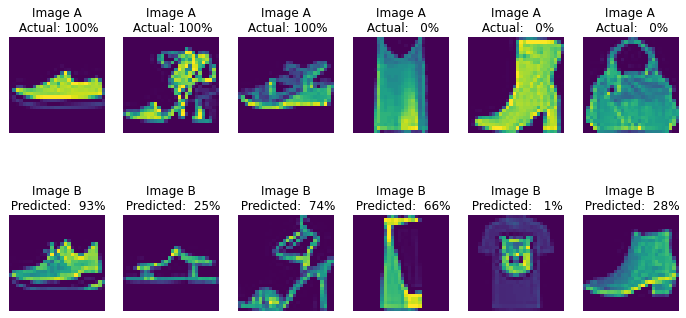

In [12]:
_ = show_model_output()

In [13]:
%%time
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 1s 8ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.020s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 0.572s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.093171


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.619850
[t-SNE] KL divergence after 500 iterations: 1.659779
CPU times: user 1min 17s, sys: 581 ms, total: 1min 18s
Wall time: 44.2 s


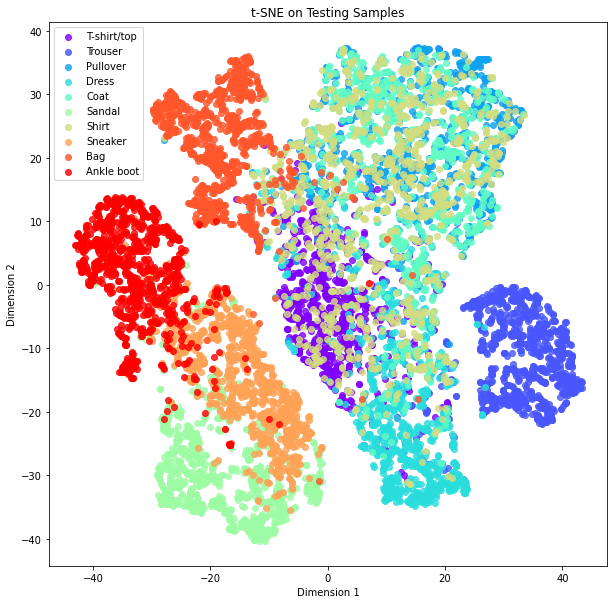

In [14]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
 plt.scatter(tsne_features[np.where(y_test == c_group), 0],
 tsne_features[np.where(y_test == c_group), 1],
 marker='o',
 color=c_color,
 linewidth='1',
 alpha=0.8,
 label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)